In [1]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
from LowLevelModules.PyAPT import APTMotor
from scipy.optimize import curve_fit
from pymeasure.instruments.thorlabs import ThorlabsPM100USB

def pol_fit_func(xx, a0, c0, x0):
    return a0 * np.cos(2*np.pi/180 * (xx-x0)) + c0

In [2]:
# initialize the power meter if not using APDs
PM = ThorlabsPM100USB('USB0::0x1313::0x8078::P0021814::INSTR')
PM.measure_power(535)*1e6

-0.0348526683

In [28]:
from LowLevelModules.NIdaqAPD import APDCounter
from LowLevelModules.GeneralFunctions import *

import time
import ipywidgets as widgets
from IPython.display import display

# initialize the HWP motors
hwp = {}
hwp['Emission'] = APTMotor(83853557, HWTYPE=31)
hwp['Emission'].setVelocityParameters(0, 25, 25)
print("HWP in emission ready to use")
hwp['Absorption'] = APTMotor(83857433, HWTYPE=31)
hwp['Absorption'].setVelocityParameters(0, 25, 25)
hwp['Absorption'].mAbs(0)
print("HWP in absorption ready to use and initialized to zero")
#calibration 3/7/19. Collection polarizer GL10 offset by 21.5 degrees, no pellicule in path
#calibration 3/22/19. Collection polarizer Lin Pol offset by 67 degrees, no pellicule in path
offset_col = -77.5

HWP in emission ready to use
HWP in absorption ready to use and initialized to zero


In [17]:
# make some checkboxes for easy selection of different parameters
savedata_choice = widgets.Checkbox(value=False, description='Save data')
fitdata_choice = widgets.Checkbox(value=True, description='Sine fit data')
mode_choice = widgets.RadioButtons(options=['Absorption', 'Emission'], value='Emission', description='HWP choice')
detector_choice = widgets.RadioButtons(options=['APD', 'Power meter'], value='APD', description='Detector')
display(savedata_choice)
display(fitdata_choice)
display(mode_choice)
display(detector_choice)

Checkbox(value=False, description='Save data')

Checkbox(value=True, description='Sine fit data')

RadioButtons(description='HWP choice', index=1, options=('Absorption', 'Emission'), value='Emission')

RadioButtons(description='Detector', options=('APD', 'Power meter'), value='APD')

# Move HWP to a given position

In [53]:
go_to_position = 0
offset = offset_col if mode_choice.value == 'Emission' else 0
hwp[mode_choice.value].mAbs((go_to_position+offset)/2)
pos_current = 2 * hwp[mode_choice.value].getPos()
print('Current position of %s waveplate: %f' % (mode_choice.value, pos_current))
excitation_offset = hwp['Absorption'].getPos() * 2
excitation_offset

Current position of Absorption waveplate: 719.997803


719.997802734375

# Run a polarization scan

0


<IPython.core.display.Javascript object>


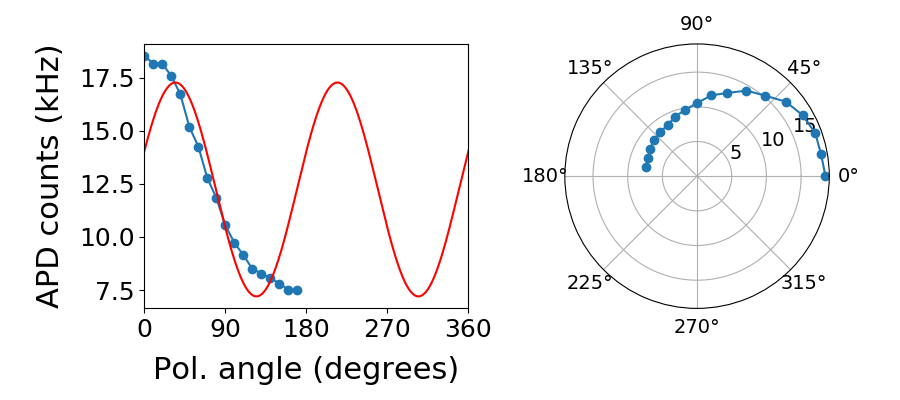

Polarization max:  34.48 degrees    and       214.48  degrees
Extinction = 1:2.0
Visibility = 0.411


c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\nidaqmx\task.py:463: ResourceWarning: Attempted to close NI-DAQmx task of name "Pol counts" but task was already closed.
  'already closed.'.format(self._saved_name), DaqResourceWarning)


In [52]:
"""#######################################   Default parameters   #########################################"""
terminal = "/Dev1/PFI5"   # APD that has the HWP and polarizer in front
ang_step = 10
collection_time = 1   # seconds
bgd_level = -0.088    # value on detector when laser is off

"""#########################################################################################################"""
offset = offset_col if mode_choice.value == 'Emission' else 0
print(offset)
y_axis_label = 'APD counts (kHz)' if detector_choice.value == 'APD' else 'Power (μW)'
lp = LivePlot(2, 1, 9, 4, 'o', 'Pol. angle (degrees)', y_axis_label)

pos, cts = [], []
for p in np.arange(0, 370, ang_step):
    try:
        # move HWP to new position
        hwp[mode_choice.value].mAbs((p+offset)/2)
        # collect the APD count rate
        if detector_choice.value == 'APD':
            APD1 = APDCounter(terminal, task_name='Pol counts')
            APD1.start()
            time.sleep(collection_time)
            curr_cts = APD1.read() / collection_time / 1000
            APD1.close()
        elif detector_choice.value == 'Power meter':
            time.sleep(collection_time)
            curr_cts = PM.power * 1e6 - bgd_level
        # get the new data and update the plot
        pos.append(p)
        cts.append(curr_cts)
        lp.plot_live(pos, cts)
    except KeyboardInterrupt:
        # press the stop button to trigger this
        if detector_choice.value == 'APD':
            APD1.close()
        break

lp.ax1.set_xlim([0, 360])
lp.ax1.set_xticks(np.arange(0,370,90))

if fitdata_choice:
    data_x = np.array(pos)
    data_y = np.array(cts)
    # guess fit parameters
    guess_mean = np.mean(data_y)
    guess_std = 3*np.std(data_y)/(2**0.5)/(2**0.5)
    coeffs, _ = curve_fit(pol_fit_func, data_x, data_y, p0=[guess_std, guess_mean, 0])
    x_fit = np.arange(0, 370, ang_step/10)
    y_fit = pol_fit_func(x_fit, *coeffs)
    lp.ax1.plot(x_fit, y_fit, 'r-')
    pol_max = np.round(coeffs[2],2)
    print('Polarization max: ', pol_max, 'degrees    and      ', pol_max + 180, ' degrees' )
    vis = (np.max(y_fit) - np.min(y_fit)) / (np.max(y_fit) + np.min(y_fit))
    print(f'Extinction = 1:{np.round(np.max(y_fit)/np.min(y_fit))}')
    print(f'Visibility = {np.round(vis,3)}')
    
if savedata_choice.value:
    data_type = 'PLvsTheta'
    data_header = f"{mode_choice.value} HWP angle (degrees)     {detector_choice.value}"
    data_array = np.array([pos, cts]).T
    save_file_names = data_save(data_array, lp.fig, data_type, data_header)
    #print(save_file_names)

# Run this to shut down the connection with the drivers

In [59]:
hwp['Absorption'].cleanUpAPT()
hwp['Emission'].cleanUpAPT()

In [9]:
np.min(y_fit)

-0.14678127185308654